## All Terminals KPIs Visualization


=== KPI SUMMARY TABLE ===
  Terminal  Quay Length (m)  Total Unique Vessels  Berthed Vessels  Avg Turnaround (hr)  Median Turnaround (hr)  Berth Occupancy Rate (%)
   Aalborg              609                   164               38            27.276618                   19.85                 10.709070
   Aarhaus             1240                   224               62            17.841346                   14.35                 17.897934
Copenhagen              935                    51               18            17.062794                   14.46                  7.022072
Fredericia             1610                   201              142            26.634315                   20.73                 22.208910


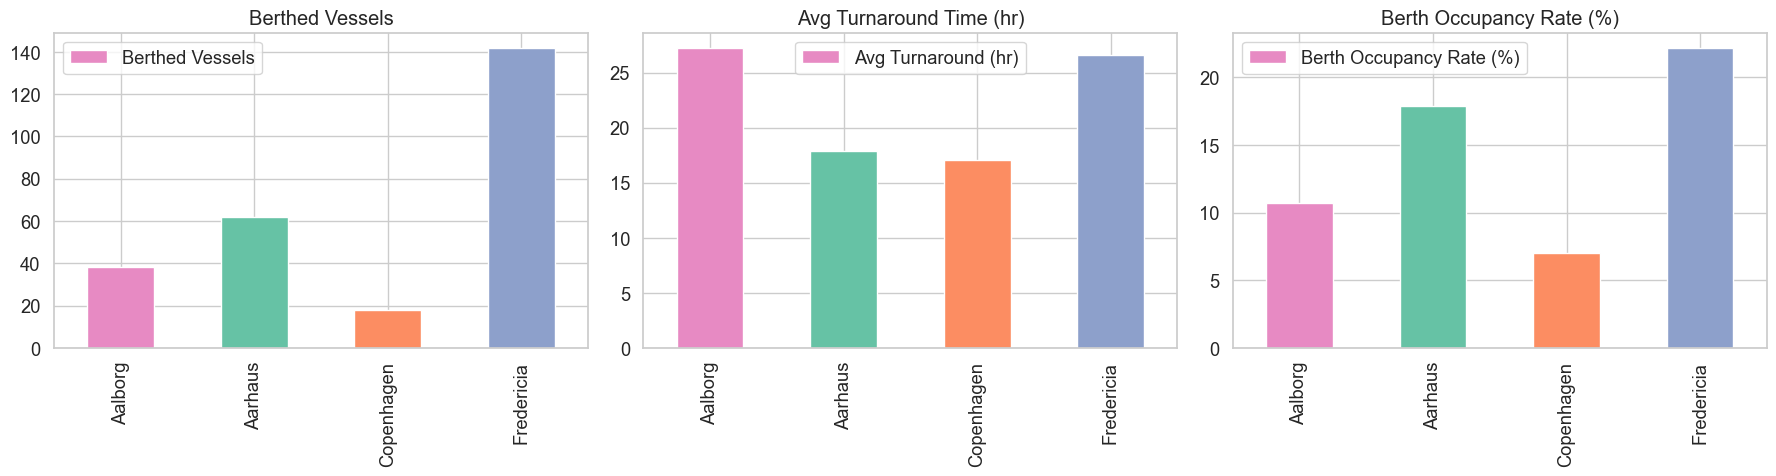

C:\Users\herox\AppData\Local\Temp\ipykernel_20844\1859284214.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


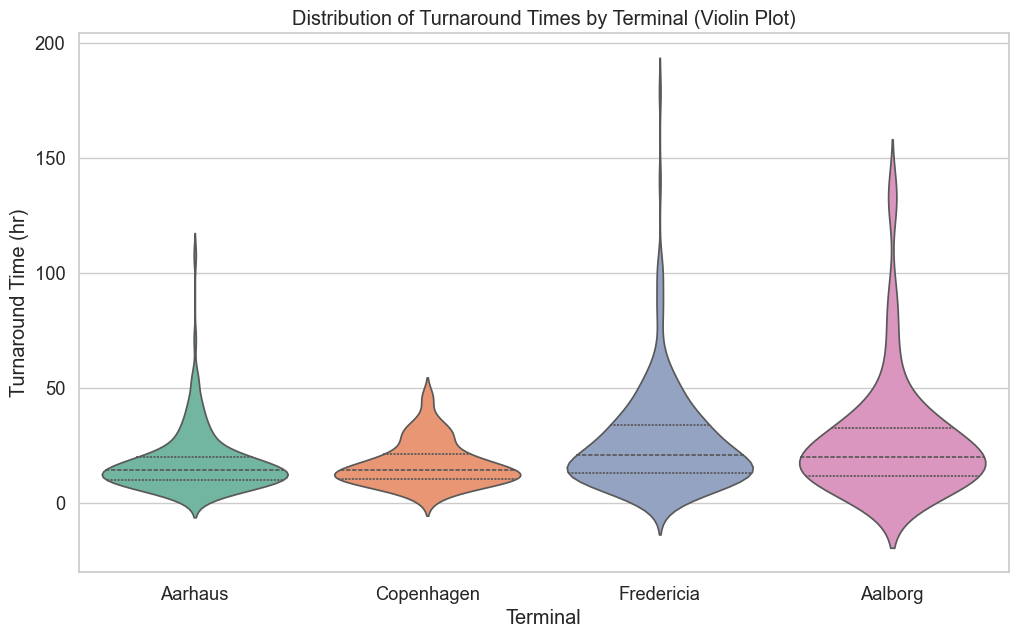

C:\Users\herox\AppData\Local\Temp\ipykernel_20844\1859284214.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


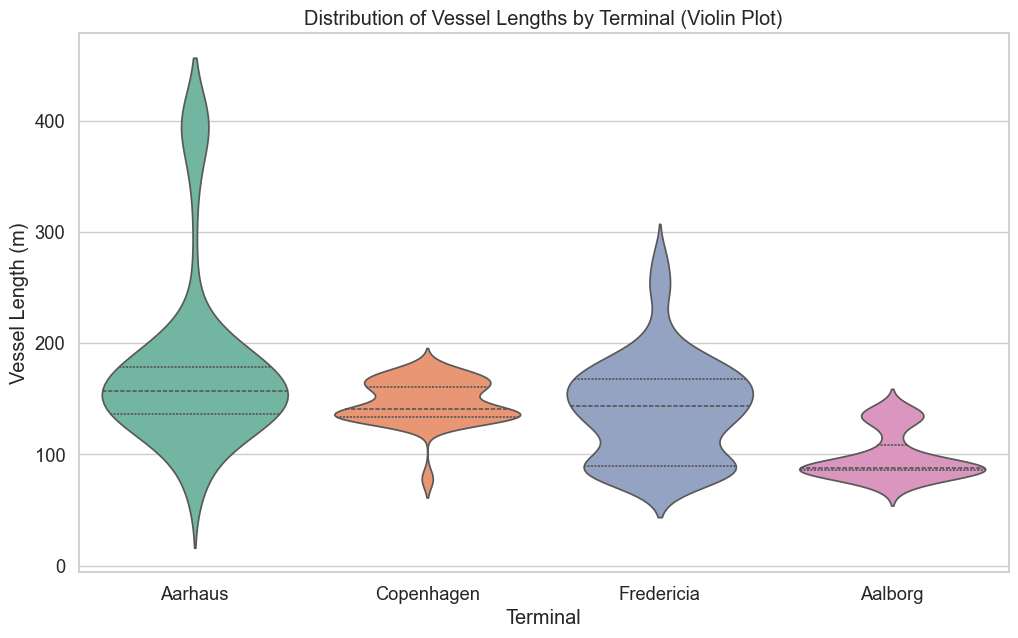

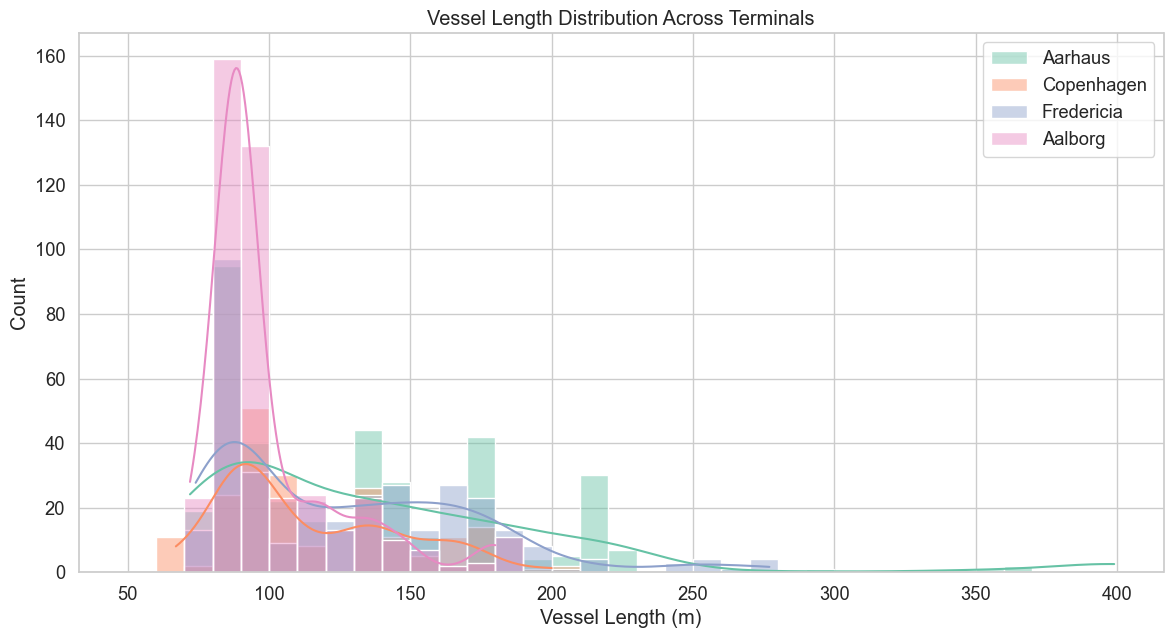

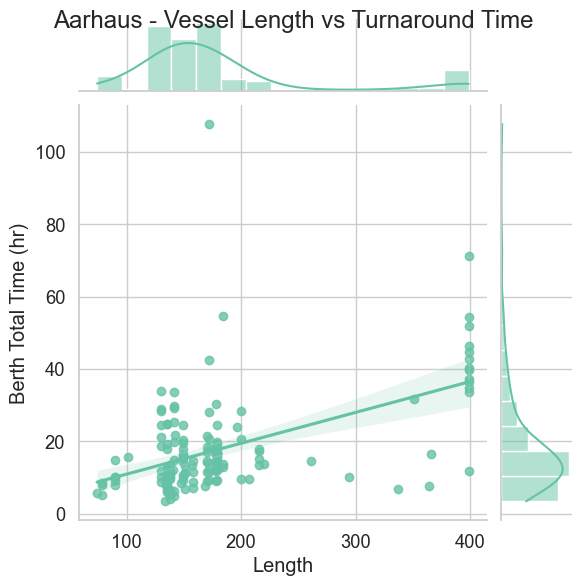

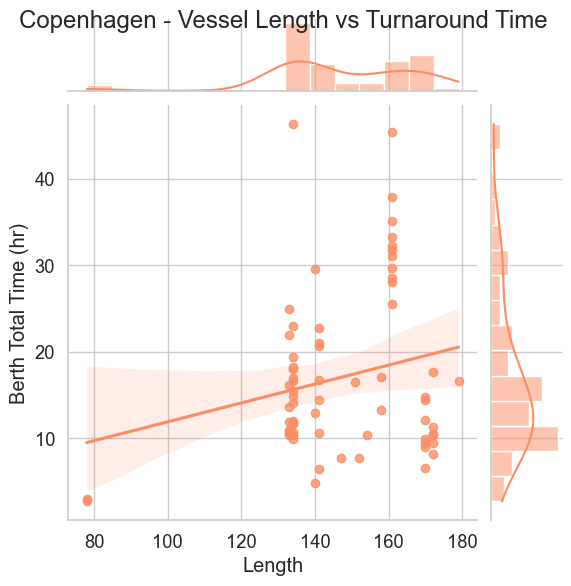

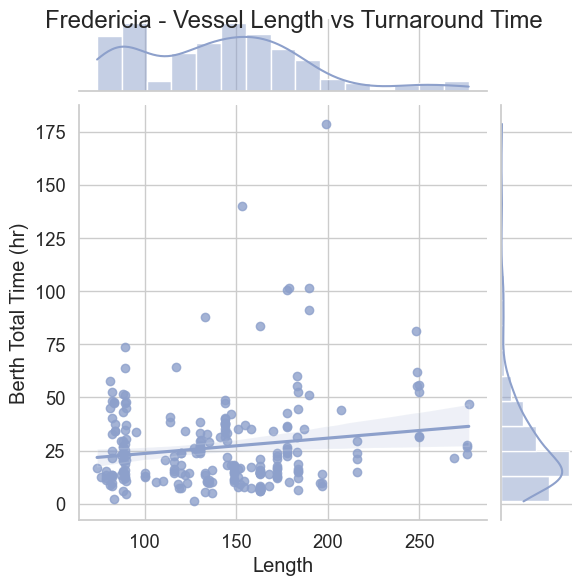

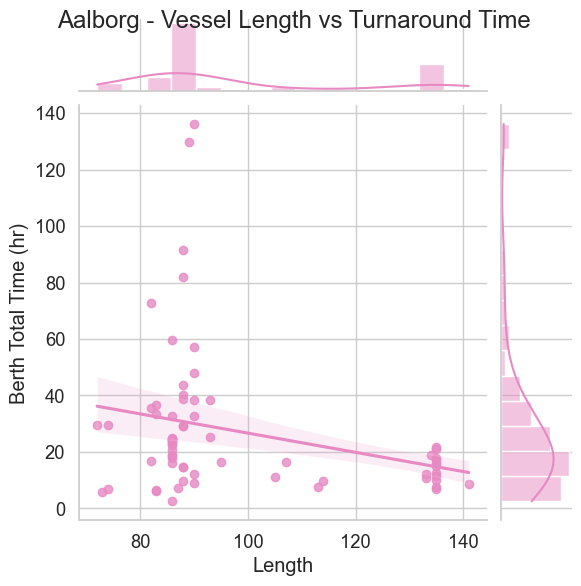

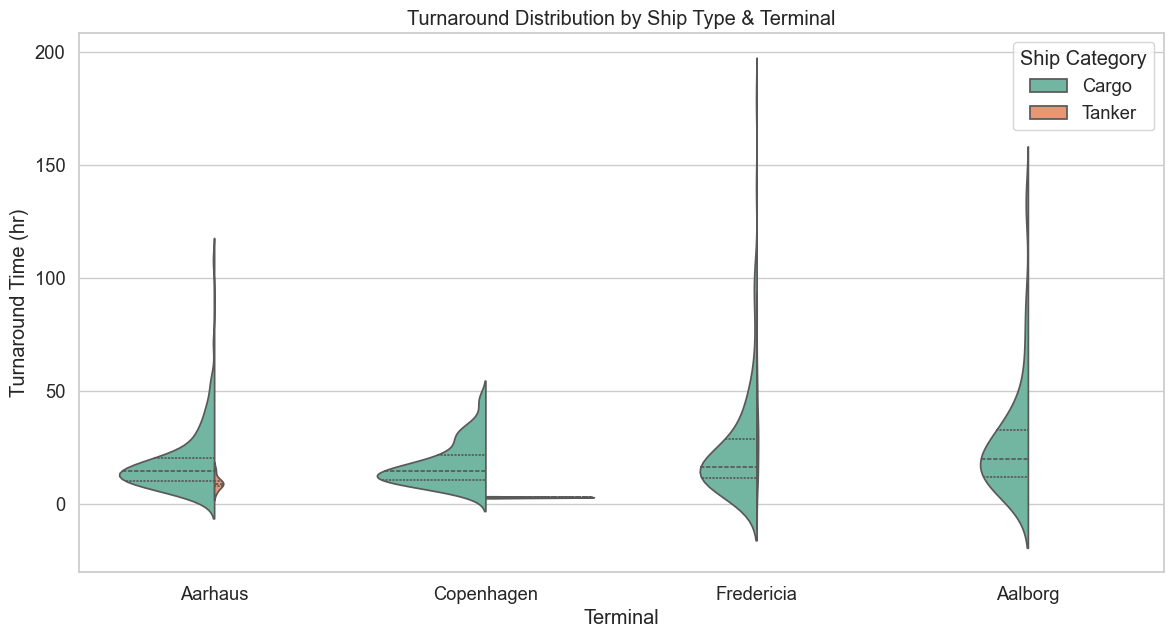


--- DONE: Visualizations Ready ---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# -- Terminal settings --
summary_files = {
    "Aarhaus":       ("Aarhaus_kpi_summary.csv", 1240),
    "Copenhagen":    ("Copenhagen_kpi_summary.csv", 935),
    "Fredericia":    ("Fredericia_kpi_summary.csv", 1610),
    "Aalborg":       ("Aalborg_kpi_summary.csv", 609)
}
summary_dir = Path(r"D:\Thesis Work MLS\Denmark AIS data\processed_files\kpi_summaries")

# -- Read and annotate each summary --
dfs = []
for terminal, (fname, quay_len) in summary_files.items():
    df = pd.read_csv(summary_dir / fname, parse_dates=['Visit Start', 'Visit End'])
    df['Terminal'] = terminal
    df['Quay_Length'] = quay_len
    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)
all_df['visited_terminal'] = all_df['Berth Events (>=0.5hr)'] > 0
all_df['ship_category'] = all_df['Ship Type'].apply(
    lambda x: 'Cargo' if 'cargo' in str(x).lower() 
    else 'Tanker' if 'tanker' in str(x).lower() 
    else 'Other'
)

# --- Prepare KPI Table ---
kpi_summary = []
for terminal, group in all_df.groupby('Terminal'):
    quay = group['Quay_Length'].iloc[0]
    berthed = group[group['visited_terminal']]
    unique_berthed = berthed['MMSI'].nunique()
    avg_turnaround = berthed['Berth Total Time (hr)'].mean()
    med_turnaround = berthed['Berth Total Time (hr)'].median()
    berth_occupancy = berthed.apply(lambda row: row['Length'] * row['Berth Total Time (hr)'], axis=1).sum() / (quay * (group['Visit End'].max() - group['Visit Start'].min()).total_seconds()/3600)
    total_vessels = group['MMSI'].nunique()
    kpi_summary.append({
        'Terminal': terminal,
        'Quay Length (m)': quay,
        'Total Unique Vessels': total_vessels,
        'Berthed Vessels': unique_berthed,
        'Avg Turnaround (hr)': avg_turnaround,
        'Median Turnaround (hr)': med_turnaround,
        'Berth Occupancy Rate (%)': berth_occupancy * 100,
    })
kpi_df = pd.DataFrame(kpi_summary)

print("\n=== KPI SUMMARY TABLE ===")
print(kpi_df.to_string(index=False))

# --- Plotting settings ---
sns.set(style="whitegrid", font_scale=1.2, palette="Set2")
color_map = dict(zip(summary_files.keys(), sns.color_palette("Set2", n_colors=4)))

# 1. Grouped Bar: Berthed vessels, Avg turnaround, Occupancy
fig, axs = plt.subplots(1, 3, figsize=(18,5))
kpi_df.plot.bar(x='Terminal', y='Berthed Vessels', ax=axs[0], color=[color_map[x] for x in kpi_df['Terminal']])
axs[0].set_title('Berthed Vessels')
kpi_df.plot.bar(x='Terminal', y='Avg Turnaround (hr)', ax=axs[1], color=[color_map[x] for x in kpi_df['Terminal']])
axs[1].set_title('Avg Turnaround Time (hr)')
kpi_df.plot.bar(x='Terminal', y='Berth Occupancy Rate (%)', ax=axs[2], color=[color_map[x] for x in kpi_df['Terminal']])
axs[2].set_title('Berth Occupancy Rate (%)')
for ax in axs:
    ax.set_xlabel('')
plt.tight_layout()
plt.show()

# 2. Violinplot: Turnaround times for each terminal
plt.figure(figsize=(12,7))
sns.violinplot(
    data=all_df[all_df['visited_terminal']],
    x='Terminal', y='Berth Total Time (hr)', palette=color_map, inner='quartile'
)
plt.title("Distribution of Turnaround Times by Terminal (Violin Plot)")
plt.ylabel("Turnaround Time (hr)")
plt.show()

# 3. Violinplot: Vessel Lengths by Terminal
plt.figure(figsize=(12,7))
sns.violinplot(
    data=all_df[all_df['visited_terminal']],
    x='Terminal', y='Length', palette=color_map, inner='quartile'
)
plt.title("Distribution of Vessel Lengths by Terminal (Violin Plot)")
plt.ylabel("Vessel Length (m)")
plt.show()

# 4. Vessel Length Histogram (all vessels, not just berthed)
plt.figure(figsize=(14,7))
for term, color in color_map.items():
    term_data = all_df[all_df['Terminal'] == term]
    sns.histplot(term_data['Length'], label=term, color=color, kde=True, bins=np.arange(50, 400, 10), alpha=0.45)
plt.title("Vessel Length Distribution Across Terminals")
plt.xlabel("Vessel Length (m)")
plt.ylabel("Count")
plt.legend()
plt.show()

# 5. (Optional) Seaborn Jointplot: Length vs Turnaround for all terminals
for term in summary_files:
    berthed = all_df[(all_df['Terminal'] == term) & (all_df['visited_terminal'])]
    if len(berthed) > 5:
        g = sns.jointplot(
            data=berthed,
            x="Length",
            y="Berth Total Time (hr)",
            kind="reg",
            marginal_kws=dict(bins=15, fill=True),
            color=color_map[term]
        )
        g.fig.suptitle(f"{term} - Vessel Length vs Turnaround Time")
        plt.show()

# 6. (Optional) Violinplot: Turnaround times for Cargo vs Tanker by Terminal
plt.figure(figsize=(14,7))
sns.violinplot(
    data=all_df[(all_df['visited_terminal']) & (all_df['ship_category'].isin(['Cargo','Tanker']))],
    x='Terminal', y='Berth Total Time (hr)', hue='ship_category',
    split=True, palette='Set2', inner='quartile'
)
plt.title("Turnaround Distribution by Ship Type & Terminal")
plt.ylabel("Turnaround Time (hr)")
plt.legend(title="Ship Category")
plt.show()

print("\n--- DONE: Visualizations Ready ---")


In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from dash import Dash, dcc, html, dash_table
import dash_bootstrap_components as dbc

# --- Terminal file info ---
TERMINALS = [
    {"name": "Aarhaus", "file": "Aarhaus_kpi_summary.csv", "quay": 1240},
    {"name": "Copenhagen", "file": "Copenhagen_kpi_summary.csv", "quay": 935},
    {"name": "Fredericia", "file": "Fredericia_kpi_summary.csv", "quay": 1610},
    {"name": "Aalborg", "file": "Aalborg_kpi_summary.csv", "quay": 609}
]
BASE_PATH = "D:/Thesis Work MLS/Denmark AIS data/processed_files/kpi_summaries"

# --- Load & prepare all data ---
summary_dfs = []
for t in TERMINALS:
    df = pd.read_csv(f"{BASE_PATH}/{t['file']}", parse_dates=['Visit Start', 'Visit End'])
    df['terminal'] = t['name']
    df['quay_length'] = t['quay']
    summary_dfs.append(df)
summary = pd.concat(summary_dfs, ignore_index=True)

summary['ship_category'] = summary['Ship Type'].apply(
    lambda x: 'Cargo' if 'cargo' in str(x).lower() else 'Tanker' if 'tanker' in str(x).lower() else 'Other'
)
summary['visited_terminal'] = summary['Berth Events (>=0.5hr)'] > 0

# --- KPI aggregation for bar graphs ---
agg_data = summary.groupby('terminal').agg(
    unique_vessels=('MMSI', 'nunique'),
    berthed_vessels=('visited_terminal', lambda x: summary.loc[x.index, 'MMSI'][x].nunique()),
    avg_turnaround=('Berth Total Time (hr)', lambda x: x[summary.loc[x.index, 'visited_terminal']].mean()),
    quay_length=('quay_length', 'first')
).reset_index()

# --- Vessel length distribution per terminal ---
length_bins = [50, 80, 110, 140, 170, 200, 250, 400]
length_labels = [f"{length_bins[i]}-{length_bins[i+1]}" for i in range(len(length_bins)-1)]
summary['Length Bin'] = pd.cut(summary['Length'], bins=length_bins, labels=length_labels, right=False)

length_dist = summary.groupby(['terminal', 'Length Bin']).agg(
    vessel_count=('MMSI', 'nunique')
).reset_index()

# --- Vessel turnaround time vs length (scatter per terminal) ---
turnaround_data = summary[summary['visited_terminal']].copy()

# --- Berth Occupancy Rate ---
# (Sum of (Vessel Length × Duration)) / (Quay Length × Total Time Window)
occupancy_list = []
for t in TERMINALS:
    df = summary[summary['terminal'] == t['name']]
    quay = t['quay']
    # For total time window: use the range of 'Visit Start' to 'Visit End'
    if df['Visit Start'].notnull().any() and df['Visit End'].notnull().any():
        period_hours = (df['Visit End'].max() - df['Visit Start'].min()).total_seconds() / 3600
        sum_len_time = df[df['visited_terminal']].eval('Length * `Berth Total Time (hr)`').sum()
        occupancy = sum_len_time / (quay * period_hours) if period_hours > 0 else np.nan
        occupancy_list.append({
            "Terminal": t['name'],
            "Quay Length (m)": quay,
            "Occupancy Rate": occupancy
        })
    else:
        occupancy_list.append({
            "Terminal": t['name'],
            "Quay Length (m)": quay,
            "Occupancy Rate": np.nan
        })
occupancy_df = pd.DataFrame(occupancy_list)

# --- Dash/Plotly Layouts ---

# Colors for length bars (brighter, better for presentation)
TERMINAL_COLORS = {
    'Aarhaus': '#2980B9',
    'Copenhagen': '#16A085',
    'Fredericia': '#9B59B6',
    'Aalborg': '#E67E22'
}

# --- App code ---
app = Dash(__name__, external_stylesheets=[dbc.themes.COSMO])

app.layout = dbc.Container([
    html.H2("Danish Port Terminals - KPI Overview Dashboard", style={'marginTop': '18px', 'textAlign': 'center'}),

    dbc.Row([
        dbc.Col(dcc.Graph(
            figure=go.Figure([
                go.Bar(
                    x=agg_data['terminal'],
                    y=agg_data['unique_vessels'],
                    marker_color=[TERMINAL_COLORS[t] for t in agg_data['terminal']],
                    text=agg_data['unique_vessels'],
                    textposition='auto'
                )
            ]).update_layout(
                title='Total Unique Vessels Found',
                plot_bgcolor='white', yaxis=dict(title="Unique Vessels", gridcolor='gainsboro'),
                xaxis=dict(title="Terminal")
            )
        ), width=4),

        dbc.Col(dcc.Graph(
            figure=go.Figure([
                go.Bar(
                    x=agg_data['terminal'],
                    y=agg_data['berthed_vessels'],
                    marker_color=[TERMINAL_COLORS[t] for t in agg_data['terminal']],
                    text=agg_data['berthed_vessels'],
                    textposition='auto'
                )
            ]).update_layout(
                title='Vessels Berthed (≥0.5hr)',
                plot_bgcolor='white', yaxis=dict(title="Berthed Vessels", gridcolor='gainsboro'),
                xaxis=dict(title="Terminal")
            )
        ), width=4),

        dbc.Col(dcc.Graph(
            figure=go.Figure([
                go.Bar(
                    x=agg_data['terminal'],
                    y=agg_data['avg_turnaround'],
                    marker_color=[TERMINAL_COLORS[t] for t in agg_data['terminal']],
                    text=[f"{v:.1f} h" if not np.isnan(v) else "-" for v in agg_data['avg_turnaround']],
                    textposition='auto'
                )
            ]).update_layout(
                title='Avg Turnaround Time (hr, Berthed)',
                plot_bgcolor='white', yaxis=dict(title="Avg Turnaround Time (hr)", gridcolor='gainsboro'),
                xaxis=dict(title="Terminal")
            )
        ), width=4),
    ]),

    html.Hr(),

    html.H4("Vessel Length Distribution Across Terminals (Hover for details)"),
    dcc.Graph(
        id='length-dist-bar',
        figure=go.Figure([
            go.Bar(
                name=terminal,
                x=length_labels,
                y=length_dist[length_dist['terminal']==terminal]['vessel_count'],
                marker_color=TERMINAL_COLORS[terminal],
                text=length_dist[length_dist['terminal']==terminal]['vessel_count'],
                hoverinfo='text',
                hovertext=[
                    f"Terminal: {terminal}<br>Length: {bin_}<br>Vessel Count: {count}"
                    for bin_, count in zip(
                        length_dist[length_dist['terminal']==terminal]['Length Bin'],
                        length_dist[length_dist['terminal']==terminal]['vessel_count']
                    )
                ]
            ) for terminal in agg_data['terminal']
        ]).update_layout(
            barmode='group',
            plot_bgcolor='white',
            yaxis=dict(title="Unique Vessels", gridcolor='gainsboro'),
            xaxis=dict(title="Vessel Length Bin (m)"),
            title='Vessel Length Bin Distribution'
        )
    ),

    html.Hr(),

    html.H4("Turnaround Time vs Vessel Length per Terminal"),
    dbc.Row([
        dbc.Col(dcc.Graph(
            id=f'turn-vs-length-{t.lower()}',
            figure=go.Figure(
                go.Scatter(
                    x=turnaround_data[turnaround_data['terminal']==t]['Length'],
                    y=turnaround_data[turnaround_data['terminal']==t]['Berth Total Time (hr)'],
                    mode='markers',
                    marker=dict(size=8, color=TERMINAL_COLORS[t], opacity=0.7, line=dict(width=1, color='#333')),
                    text=turnaround_data[turnaround_data['terminal']==t]['MMSI'],
                    hovertemplate="MMSI: %{text}<br>Length: %{x} m<br>Turnaround: %{y:.1f} h<extra></extra>"
                )
            ).update_layout(
                title=f"{t}", height=300, width=320,
                plot_bgcolor='white',
                xaxis_title='Vessel Length (m)',
                yaxis_title='Turnaround (hr)',
                margin=dict(l=40, r=10, b=40, t=35),
                yaxis=dict(gridcolor='gainsboro'),
            )
        ), width=3) for t in agg_data['terminal']
    ]),

    html.Hr(),

    html.H4("Berth Occupancy Rate Comparison (Quay Length Annotated)"),
    dcc.Graph(
        figure=go.Figure([
            go.Bar(
                x=occupancy_df['Terminal'],
                y=occupancy_df['Occupancy Rate']*100, # percent
                marker_color=[TERMINAL_COLORS[t] for t in occupancy_df['Terminal']],
                text=[
                    f"{v*100:.2f}%<br>Quay: {int(q)}m"
                    if not np.isnan(v) else "-"
                    for v, q in zip(occupancy_df['Occupancy Rate'], occupancy_df['Quay Length (m)'])
                ],
                textposition='outside',
                hovertemplate="Terminal: %{x}<br>Occupancy Rate: %{y:.2f}%<br>Quay Length: %{text}<extra></extra>"
            )
        ]).update_layout(
            title="Berth Occupancy Rate (All Vessels, Full Period, Annotated with Quay Length)",
            plot_bgcolor='white',
            yaxis=dict(title="Occupancy Rate (%)", gridcolor='gainsboro'),
            xaxis=dict(title="Terminal"),
            showlegend=False
        )
    )
], fluid=True)

if __name__ == '__main__':
    app.run_server(debug=True, port=8082)


C:\Users\herox\AppData\Local\Temp\ipykernel_14500\1417234446.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_dist = summary.groupby(['terminal', 'Length Bin']).agg(



=== KPI SUMMARY TABLE ===
  Terminal  Quay Length (m)  Total Unique Vessels  Berthed Vessels  Avg Turnaround (hr)  Median Turnaround (hr)  Berth Occupancy Rate (%)
   Aalborg              609                   164               38            27.276618                   19.85                 10.709070
   Aarhaus             1240                   224               62            17.841346                   14.35                 17.897934
Copenhagen              935                    51               18            17.062794                   14.46                  7.022072
Fredericia             1610                   201              142            26.634315                   20.73                 22.208910


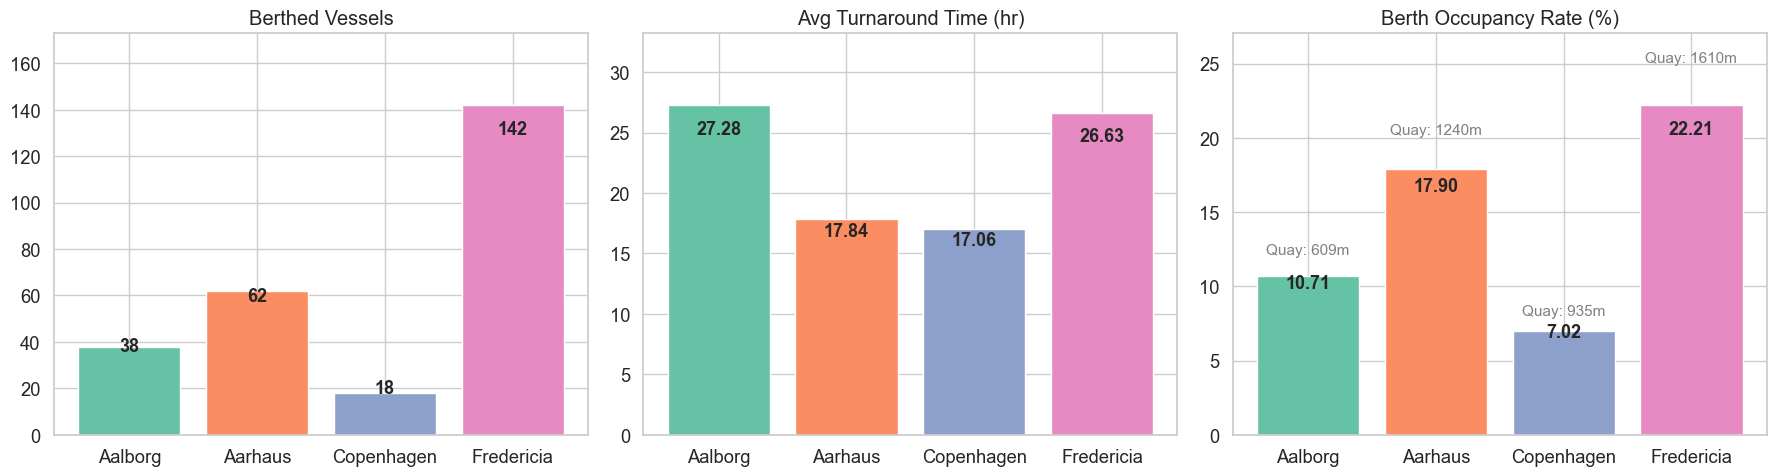

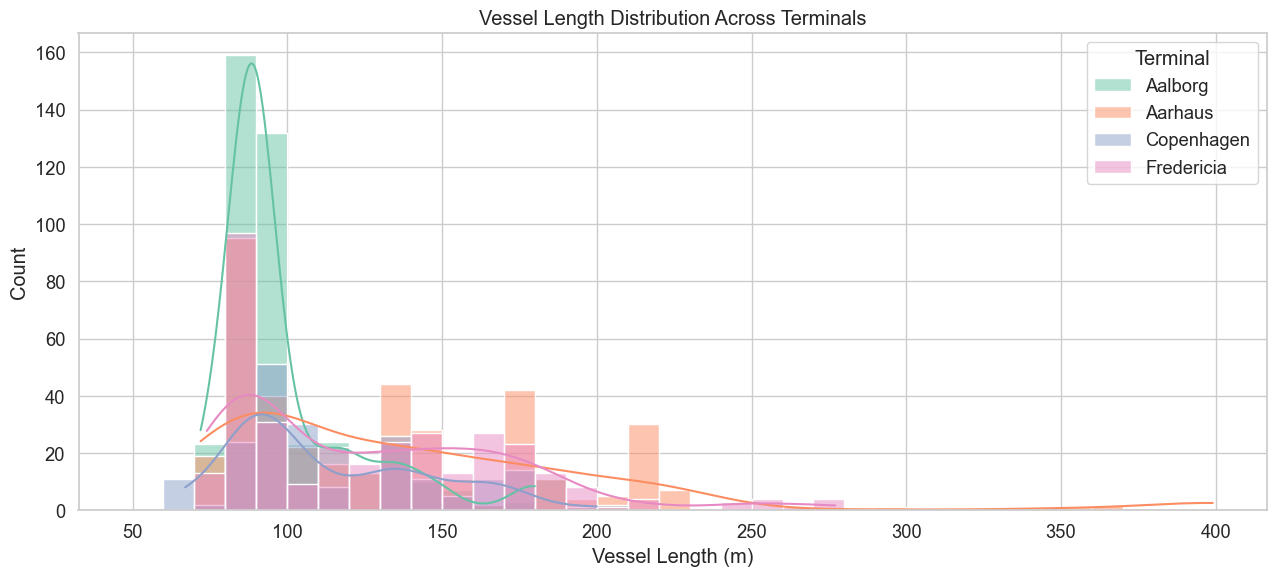

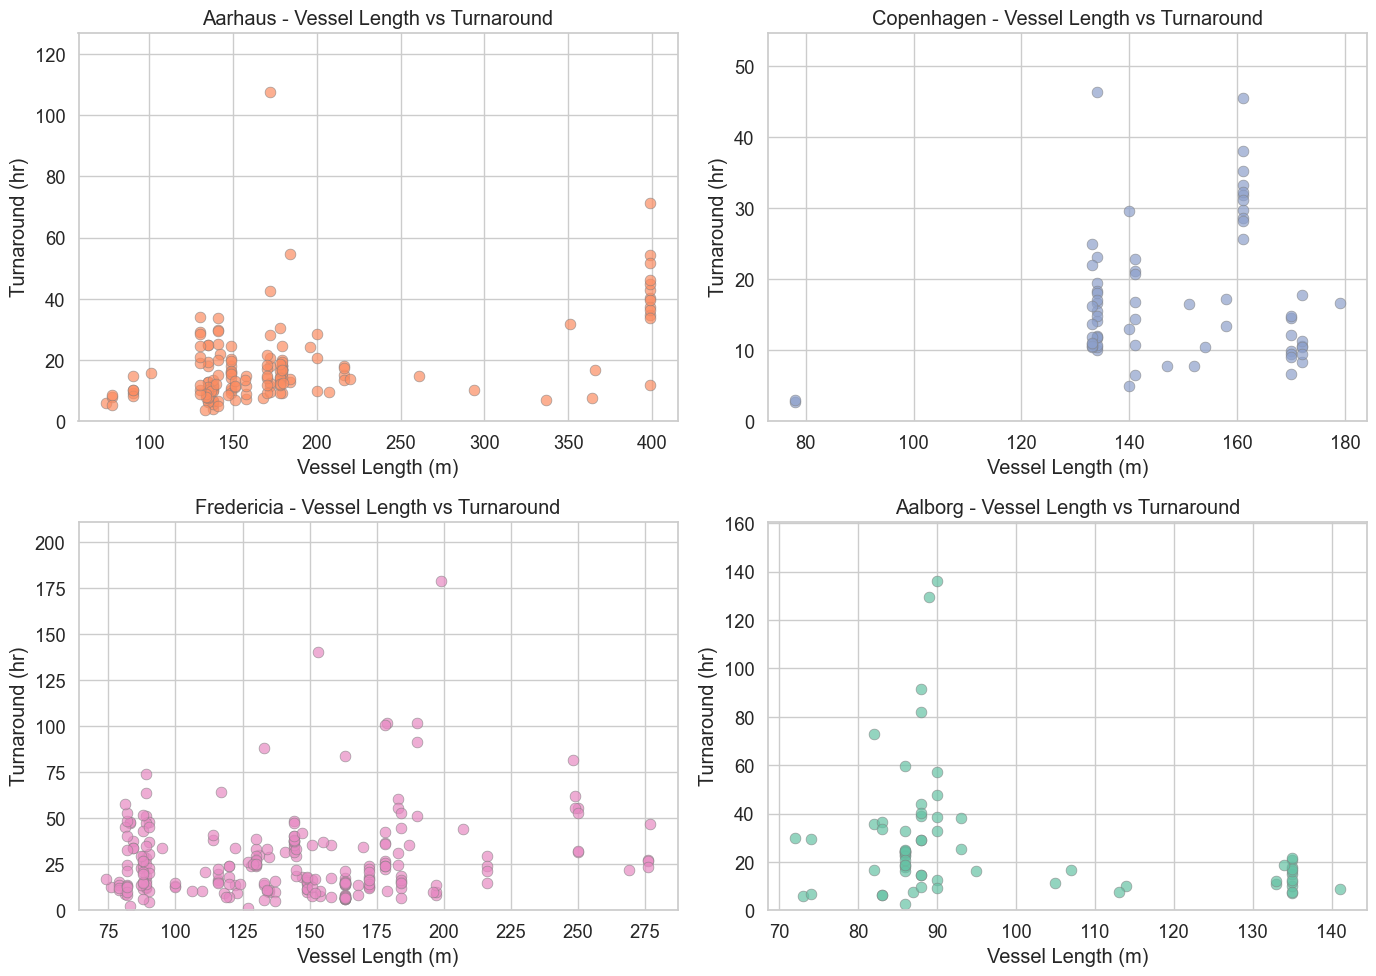


--- DONE: Visualizations Ready ---


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# -- Terminal settings --
summary_files = {
    "Aarhaus":       ("Aarhaus_kpi_summary.csv", 1240),
    "Copenhagen":    ("Copenhagen_kpi_summary.csv", 935),
    "Fredericia":    ("Fredericia_kpi_summary.csv", 1610),
    "Aalborg":       ("Aalborg_kpi_summary.csv", 609)
}
summary_dir = Path(r"D:\Thesis Work MLS\Denmark AIS data\processed_files\kpi_summaries")

# -- Read and annotate each summary --
dfs = []
for terminal, (fname, quay_len) in summary_files.items():
    path = summary_dir / fname
    if not path.exists():
        raise FileNotFoundError(f"{path} does not exist!")
    df = pd.read_csv(path, parse_dates=['Visit Start', 'Visit End'])
    df['Terminal'] = terminal
    df['Quay_Length'] = quay_len
    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)
all_df['visited_terminal'] = all_df['Berth Events (>=0.5hr)'] > 0
all_df['ship_category'] = all_df['Ship Type'].apply(
    lambda x: 'Cargo' if 'cargo' in str(x).lower() 
    else 'Tanker' if 'tanker' in str(x).lower() 
    else 'Other'
)

# --- Prepare KPI Table ---
kpi_summary = []
for terminal, group in all_df.groupby('Terminal'):
    quay = group['Quay_Length'].iloc[0]
    berthed = group[group['visited_terminal']]
    unique_berthed = berthed['MMSI'].nunique()
    avg_turnaround = berthed['Berth Total Time (hr)'].mean()
    med_turnaround = berthed['Berth Total Time (hr)'].median()
    berth_occupancy = berthed.apply(lambda row: row['Length'] * row['Berth Total Time (hr)'], axis=1).sum() / (quay * (group['Visit End'].max() - group['Visit Start'].min()).total_seconds()/3600)
    total_vessels = group['MMSI'].nunique()
    kpi_summary.append({
        'Terminal': terminal,
        'Quay Length (m)': quay,
        'Total Unique Vessels': total_vessels,
        'Berthed Vessels': unique_berthed,
        'Avg Turnaround (hr)': avg_turnaround,
        'Median Turnaround (hr)': med_turnaround,
        'Berth Occupancy Rate (%)': berth_occupancy * 100,
    })
kpi_df = pd.DataFrame(kpi_summary)

print("\n=== KPI SUMMARY TABLE ===")
print(kpi_df.to_string(index=False))

# --- Plotting settings ---
sns.set(style="whitegrid", font_scale=1.2, palette="Set2")
default_colors = sns.color_palette("Set2", n_colors=4)
color_map = dict(zip(kpi_df['Terminal'], default_colors))

# 1. Grouped Bar: Berthed vessels, Avg turnaround, Occupancy
fig, axs = plt.subplots(1, 3, figsize=(18,5))

for idx, (ycol, title) in enumerate([
    ('Berthed Vessels', 'Berthed Vessels'),
    ('Avg Turnaround (hr)', 'Avg Turnaround Time (hr)'),
    ('Berth Occupancy Rate (%)', 'Berth Occupancy Rate (%)')
]):
    values = kpi_df[ycol]
    bars = axs[idx].bar(kpi_df['Terminal'], values, color=[color_map[x] for x in kpi_df['Terminal']])
    # Add values inside bars, not at the edge
    for i, bar in enumerate(bars):
        axs[idx].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() * 0.90,
            f"{values[i]:.2f}" if idx > 0 else f"{int(values[i])}",
            ha='center', va='bottom', fontweight='bold', fontsize=13
        )
    # For last bar graph, show quay length annotation as well
    if ycol == 'Berth Occupancy Rate (%)':
        for i, bar in enumerate(bars):
            axs[idx].text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() * 1.12,
                f"Quay: {kpi_df['Quay Length (m)'][i]}m",
                ha='center', va='bottom', fontsize=11, color='gray'
            )
    axs[idx].set_title(title)
    axs[idx].set_xlabel('')
    # Give Y-axis some extra headroom (10% more than max value)
    axs[idx].set_ylim(0, values.max() * 1.22)
plt.tight_layout()
plt.show()

# 2. Vessel Length Histogram (all vessels, not just berthed)
plt.figure(figsize=(13,6))
for term, color in color_map.items():
    term_data = all_df[all_df['Terminal'] == term]
    sns.histplot(term_data['Length'], label=term, color=color, kde=True, bins=np.arange(50, 400, 10), alpha=0.5, stat="count")
plt.title("Vessel Length Distribution Across Terminals")
plt.xlabel("Vessel Length (m)")
plt.ylabel("Count")
plt.legend(title="Terminal")
plt.tight_layout()
plt.show()

# 3. Vessel Length vs Turnaround Time (2x2 grid, scatter/jointplots)
plt.figure(figsize=(14,10))
terms = list(summary_files.keys())
for idx, term in enumerate(terms):
    berthed = all_df[(all_df['Terminal'] == term) & (all_df['visited_terminal'])]
    plt.subplot(2, 2, idx+1)
    if not berthed.empty:
        sns.scatterplot(
            data=berthed,
            x="Length", y="Berth Total Time (hr)",
            color=color_map[term], s=60, alpha=0.7, edgecolor='gray', linewidth=0.5
        )
    plt.title(f"{term} - Vessel Length vs Turnaround")
    plt.xlabel("Vessel Length (m)")
    plt.ylabel("Turnaround (hr)")
    plt.ylim(bottom=0)
    # Add padding to y-limits for each subplot
    yvals = berthed['Berth Total Time (hr)']
    if not yvals.empty:
        plt.ylim(0, yvals.max() * 1.18)
    # Optionally, show point MMSI or use hover, but matplotlib doesn't support tooltips

plt.tight_layout()
plt.show()



print("\n--- DONE: Visualizations Ready ---")
